In [2]:
%matplotlib inline
#data manip
import pandas as pd
import numpy as np

#data viz
from matplotlib import pyplot as plt
import seaborn as sns

#custom packages
import database_utility
import baseball_models

Load in our database helper in case we need to pull data

In [3]:
sqlite_file = 'baseball_data.sqlite'
dh = database_utility.DatabaseHelper(sqlite_file, 'baseball_key_joiner.csv')
#This will give a ValueError when using pd.read_json if the path doesn't exist
filepath = r'C:\Users\Chris\Google Drive\Programming\Baseball\Web Scraping\bbref_scraper\bbref_scraper\bbref.jl'

<h3> Batting DF Feature Importance </h3>

Run this cell if we need to create features because the CSV isn't there

In [7]:
%%time
#i exclude the last 2 months of the season which is validation data
batting_df = dh.calc_batting_fd_score(start_date = '2015-01-01', end_date = '2016-12-31')

Trying to load csvs!
Getting raw statcast data...
Gathering player lookup table. This may take a moment.
Aggregating data...
Merging bbref and statcast data...
Batting FD Score calculated! Returning data..
Wall time: 3min 9s


In [6]:
import baseball_models
fe = baseball_models.FeatureEngineer(df=batting_df)

NameError: name 'batting_df' is not defined

In [39]:
%%time
life_avgs = fe.calc_lifetime_avg()

Wall time: 16.8 s


In [40]:
%%time
rolling_avgs = fe.calc_rolling_avg()

Wall time: 1min 39s


In [41]:
%%time
ytd_avgs = fe.calc_ytd_avgs()

Wall time: 1min 2s


Now we combine the engineered features on the game_id and bring the target back in (fd_score)

In [42]:
feature_df_b = pd.merge(life_avgs, rolling_avgs, on='game_id')
feature_df_b = pd.merge(feature_df_b, ytd_avgs, on='game_id')

In [43]:
#merge in the FD score for each game
feature_df_b = pd.merge(feature_df_b, batting_df[['game_id', 'fd_score']], on='game_id')

Save to CSV for the future

In [45]:
feature_df_b.to_csv('CSV/batting_15-16_avg_life_ytd.csv', index=False, header=True)

Otherwise, load in the data from a CSV

In [4]:
feature_df_b = pd.read_csv('CSV/batting_15-16_avg_life_ytd.csv')

I take the top 10 most correlated features with the target and plot them as a heatmap.  None of these features are highly correlated with the target at all.  This is interesting, but makes sense - the FD_Score for batting is composed of 8 different attributes, so one individual feature being highly correlated is less likely. 

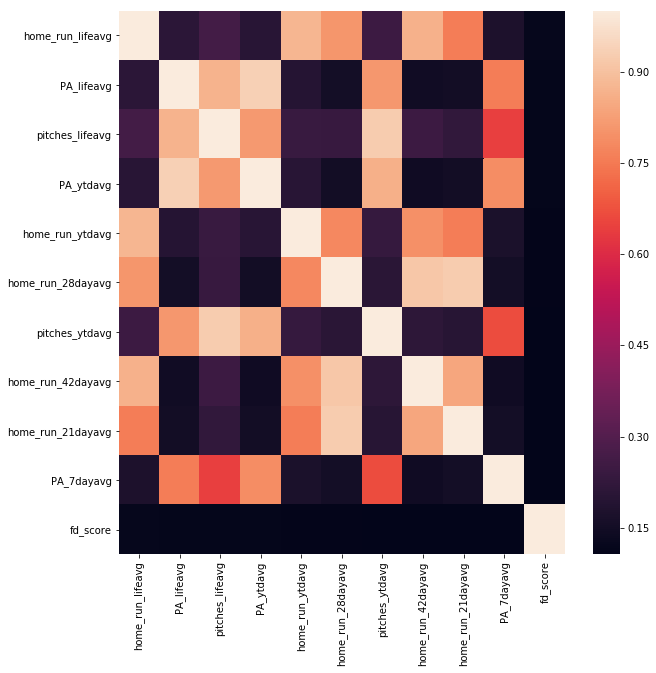

In [46]:
corr_df_b = feature_df_b.drop(['fd_score', 'game_id'], axis=1).apply(lambda x: x.corr(feature_df_b['fd_score']))
corr_df_b = corr_df_b.sort_values(ascending=False).iloc[0:10]

cols = list(corr_df_b.index.values)
cols.append('fd_score')

fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(feature_df_b[cols].corr(), xticklabels=cols, yticklabels=cols)

My next step is to look at feature importance via XGBoost and SHAP values and also evaluate model performance

In [5]:
import xgboost
import baseball_models
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

cv = baseball_models.CrossValidator()

#make sure we are sorted by time (days)
feature_df_b.sort_values(by='game_id',inplace=True)

X, y, tscv = cv.train_test_split(feature_df_b.drop('fd_score', axis=1), feature_df_b['fd_score'], num_splits=5)

#remove features that we know aren't valuable from previous feature engineering
#we can add new features that we are trying for the first time in the 'new_features parameter'
life_features = life_avgs.drop('game_id', axis=1).columns
X = cv.clean_for_model(X, batting=True, new_features = life_features)

#initialize the model
xgbreg = xgboost.XGBRegressor(silent=True, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8, 
                      n_estimators=100, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)

NameError: name 'life_avgs' is not defined

Train the model using walk-forward cross validation

In [48]:
cv.cross_validate(X, y, tscv, xgbreg)

Running iter: 1
Iter 1 took 2.345015287399292 seconds.
Running iter: 2
Iter 2 took 3.594999074935913 seconds.
Running iter: 3
Iter 3 took 5.672003269195557 seconds.
Running iter: 4
Iter 4 took 9.398019790649414 seconds.
Running iter: 5
Iter 5 took 11.999002695083618 seconds.
Running iter: 6
Iter 6 took 13.982997179031372 seconds.
Running iter: 7
Iter 7 took 16.11699938774109 seconds.
Running iter: 8
Iter 8 took 18.361000776290894 seconds.
Running iter: 9
Iter 9 took 25.515005350112915 seconds.
Running iter: 10
Iter 10 took 28.31600284576416 seconds.


We log the model performance and top performing features, as well as the data trained on for posterity

In [50]:
cv.log_model(notes="Trained for 10 iterations over 2015/2016 data with new lifetime features")

<h4> Model Analysis </h4>

Cross Validate uses sklearns TimeSeriesSplit to perform walk-forward cross validation for the number of splits indicated in the train_test_split function above.  I run this because I am curious if YTD features 'get better' as the year goes on.  I would expect to see the test MAE improve over the course of the year (as iterations increase)

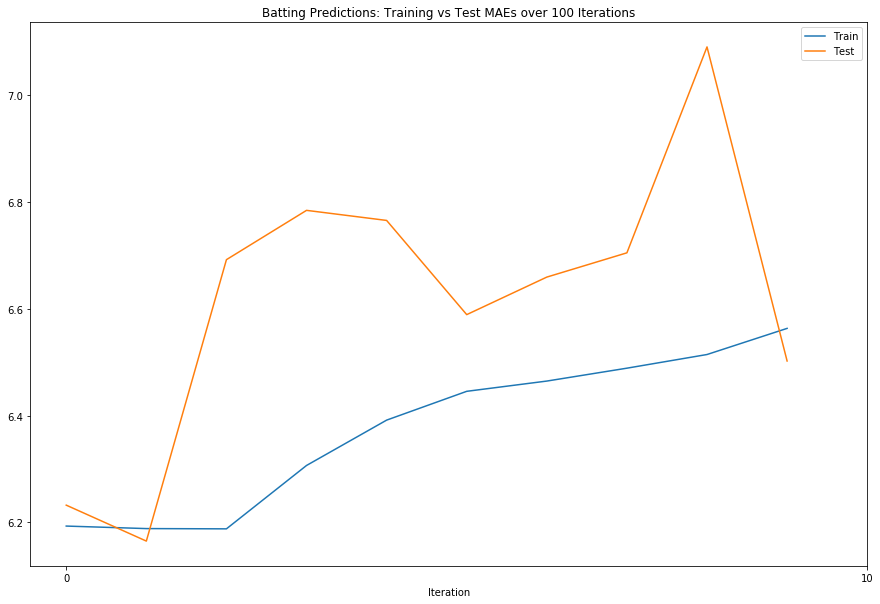

In [51]:
fig,ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(y=cv.train_maes, x=np.arange(0, len(cv.train_maes)))
ax = sns.lineplot(y=cv.test_maes, x=np.arange(0, len(cv.train_maes)), ax=ax, legend='brief')
ax.set_xticks(ticks=np.arange(0,len(cv.test_maes)+1, 10))
ax.set_xlabel(xlabel="Iteration")
ax.set_title("Batting Predictions: Training vs Test MAEs over 100 Iterations")
ax.legend(labels=['Train','Test'])
plt.show()

It looks like there is a slight trend - let's validate that the variance in the test MAE gets less as we get farther through the year.

In [ ]:
print("STDev for the first 50 iterations is: {:.2f} ".format(np.std(cv.test_maes[0:50])))
print("STDev for the last 50 iterations is: {:.2f}".format(np.std(cv.test_maes[51:100])))

Next, I want to identify which features are actually contributing to the model's predictions using SHAP values

https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83

In [54]:
batting_df['game_id'].iloc[0]

'2015-04-06Marlins Parkyounger03'

In [1]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(cv.model)
shap_values = explainer.shap_values(cv.X_train)
shap.summary_plot(shap_values, features=cv.X_train, plot_type="bar", max_display=10)

C:\Users\Chris\Anaconda3\envs\si671\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


NameError: name 'cv' is not defined

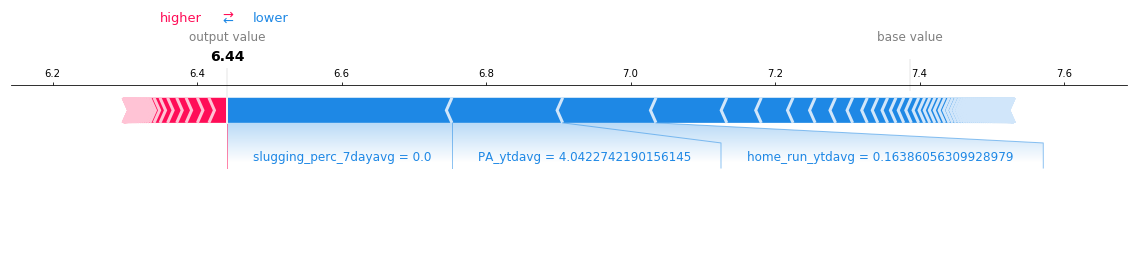

In [135]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], cv.X_train.iloc[0,:], matplotlib=True)

Finally, we can validate this by looking at some reg plots - we should see linear trends in these top features that didn't necessarily show up in the correlation matrix above. 

In [234]:
#take the top 10 in SHAP values
X_train = cv.X_train.copy()
X_train['fd_score'] = cv.y_train
top_shap_b = X_train[['slugging_perc_7dayavg', 'home_run_ytdavg', 'PA_ytdavg', 'home_run_7dayavg', 'pitches_ytdavg', 'slugging_perc_21dayavg', 'AB_ytdavg', 'strikes_total_ytdavg', 're24_bat_14dayavg', 'RBI_ytdavg', 'triple_28dayavg', 'PO_28dayavg', 'hit_by_pitch_21dayavg', 'triple_7dayavg', 'BB_28dayavg', 'fd_score']]

C:\Users\Chris\Anaconda3\envs\si671\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


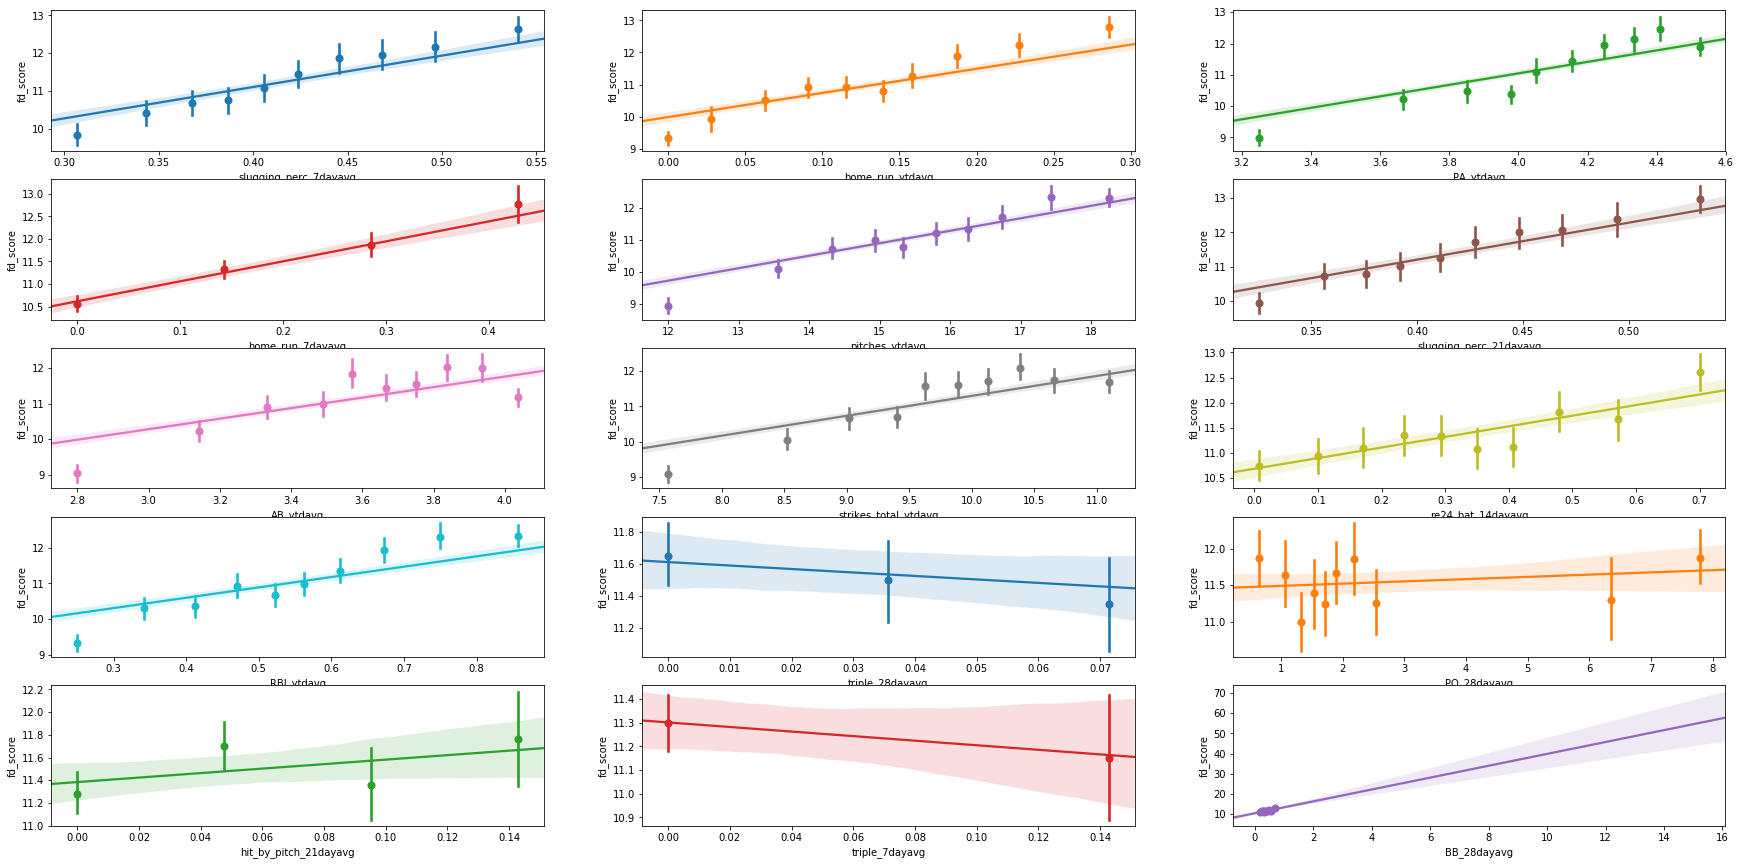

In [235]:
fig, ax = plt.subplots(5,3, figsize = (30,15), sharex=False)

axes = ax.ravel()

for i, col in enumerate(top_shap_b.columns):
    if i < len(axes):
        ax = sns.regplot(x=top_shap_b[col], y=top_shap_b['fd_score'], ax=axes[i], x_bins=10)
        ax.set(xlabel=col)

[<matplotlib.axis.XTick at 0x2413d347780>,
 <matplotlib.axis.XTick at 0x24091b88ef0>,
 <matplotlib.axis.XTick at 0x2413d3367b8>,
 <matplotlib.axis.XTick at 0x2413d36f2b0>,
 <matplotlib.axis.XTick at 0x2413d36f710>,
 <matplotlib.axis.XTick at 0x2413d36fbe0>,
 <matplotlib.axis.XTick at 0x240874a7160>,
 <matplotlib.axis.XTick at 0x240874a75c0>,
 <matplotlib.axis.XTick at 0x240874a7a90>,
 <matplotlib.axis.XTick at 0x240874a7f60>,
 <matplotlib.axis.XTick at 0x240874a7b38>,
 <matplotlib.axis.XTick at 0x2413d336be0>,
 <matplotlib.axis.XTick at 0x240874944a8>,
 <matplotlib.axis.XTick at 0x24087494978>]

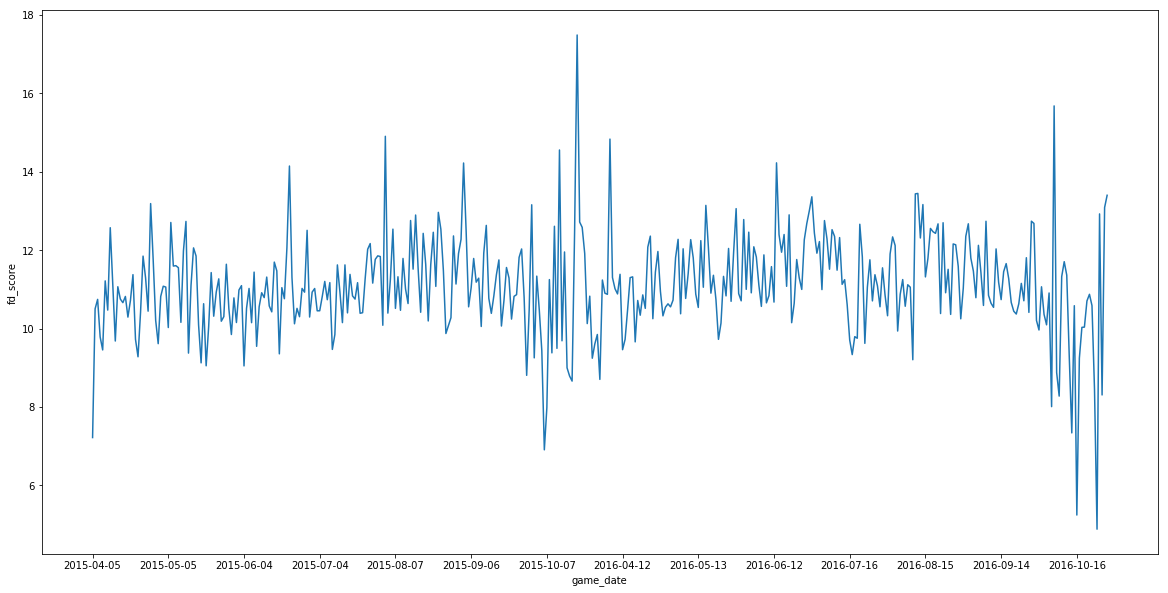

In [17]:
plt.subplots(figsize=(20,10))
ax = sns.lineplot(x=batting_df['game_date'], y=batting_df['fd_score'], ci=None)
ax.set_xticks(ticks=np.arange(0, len(batting_df['game_date'].unique()), 30))

<h3> Test Optimization Pipeline </h3>

In [149]:
import pybaseball
batter_ids = set(batting_df.player.unique())
lookup = pybaseball.playerid_reverse_lookup(list(batter_ids), key_type='bbref')

Gathering player lookup table. This may take a moment.


In [160]:
lookup.head(1)

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,abreu,jose,547989,abrej003,abreujo02,15676,2014.0,2018.0


In [1]:
import moneyball_optimizer

In [132]:
moneyball_optimizer.prep_optimization_actual_performance(game_date='2015-09-21')

In [184]:
# Historical Game Analysis (The best we could have done if we optimized on FD metrics)
rotoguru = pd.read_csv("mlb-dbd-2015.csv", sep=":", index_col=False)
rotoguru.columns = ['GID', 'MLB_ID','Name_Last_First','Name_First_Last',' P/H','Hand','Date','Team','Oppt','H/A','Game#','Game_ID','Gametime_ET','Team_score','Oppt_score','Home_Ump','Temp','Condition','W_speed','W_dir','ADI','prior_ADI','GS','GP','Pos','Order','Oppt_pitch_hand','Oppt_pich_GID','Oppt_pitch_MLB_ID','Oppt_pitch_Name','PA','wOBA_num','IP','W/L/S','QS','FD_points','DK_points','DD_points','SF_points','FD_salary','DK_salary','DD_salary','SF_salary','FD_pos','DK_pos','DD_pos','SF_pos']

rotoguru.drop(rotoguru.tail(1).index,inplace=True)

# Format Dates
rotoguru['Date'] = rotoguru['Date'].astype(str).str[:-2]
rotoguru['Date'] = pd.to_datetime(rotoguru['Date'])

# Create Last Name and First Name variables to match FD
rotoguru['Last Name'], rotoguru['First Name'] = zip(*rotoguru['Name_Last_First'].apply(lambda x: x.split(',')))

In [200]:
preds = pd.DataFrame(cv.id_preds, columns=['prediction', 'game_id'])
preds = pd.merge(preds, batting_df[['position', 'game_date', 'player', 'game_id']], on='game_id')
preds = preds.rename({'player' :'key_bbref'}, axis=1)
#bring in first and last name and mlbam - mlbam is used to identify players by rotoguru
preds = pd.merge(preds, lookup[['name_last', 'name_first', 'key_bbref', 'key_mlbam']], on='key_bbref')
#add nickname columns
preds['nickname'] = preds['name_last'] + preds['name_last']

#pick a random date
rotoguru_filtered = rotoguru[rotoguru['Date'] == '2015-09-21']
preds_filtered = preds[preds['game_date'] == '2015-09-21']

#join in other cols
preds_filtered = pd.merge(preds_filtered, rotoguru_filtered[['MLB_ID', 'FD_salary', 'Team', 'Oppt']], left_on='key_mlbam', right_on='MLB_ID')

In [207]:
#these are columns the optimizer looks for
preds_filtered['Played'] = 0
preds_filtered['Game'] = ""
preds_filtered['Injury Indicator'] = ""
preds_filtered['Injury Details'] = ""
preds_filtered['Tier'] = ""
#reset the column order to match what is expected by the optimizer
col_order = ['MLB_ID', 'position', 'name_first', 'nickname', 'name_last', 'prediction', 'Played', 'FD_salary', 'Game', 'Team', 'Oppt', 'Injury Indicator', 'Injury Details', 'Tier']
preds_filtered = preds_filtered[col_order]

#col names need to be exact, sigh
col_actual = ['Id', 'Position', 'First Name', 'Nickname', 'Last Name', 'FPPG', 'Played', 'Salary', 'Game', 'Team', 'Opponent', 'Injury Indicator', 'Injury Details', 'Tier']
preds_filtered.columns = col_actual


In [216]:
preds_filtered['Position'], preds_filtered['Position1'] = preds_filtered['Position'].str.split('-', 1).str

In [218]:
preds_filtered.drop('Position1', inplace=True, axis=1)

In [219]:
preds_filtered.to_csv('predictions_2015-09-21.csv', index=False, header=True)

In [17]:
import pandas as pd
sample = pd.read_csv('predictions_2015-09-21.csv')

In [65]:
sample['Game'] = sample['Team'] + '@' + sample['Opponent']
sample['Salary'] = sample['Salary'].astype(int)

In [23]:
sample.to_csv('predictions_2015-09-21.csv', header=True, index=False)

In [10]:
sample['Position'] = sample.Position.str.strip()

In [34]:
sample.loc[(sample['Position'] == 'CF') | (sample['Position'] == 'LF') | (sample['Position'] == 'RF'), 'Position'] = 'OF'

In [42]:
sample = pd.read_csv('predictions_2015-09-21.csv')

In [ ]:
import moneyball_optimizer
test = moneyball_optimizer.optimize_by_date(optimization_input='baseball_optimization_actual_performance.csv')

In [44]:
sample.Position.unique()

array(['OF', '3B', 'SS', 'C', 'P', '1B', '2B', 'DH'], dtype=object)

In [38]:
batting_df, pitching_df = dh.load_data()

Trying to load csvs!


In [39]:
batting_df['game_date'].max()

'2018-10-01'

In [40]:
batting_df = batting_df[batting_df['game_date'] < '2018-08-01']

In [41]:
batting_df.to_csv('batting_df_master.csv', header=True, index=False)

In [44]:
batting_df[batting_df['player'] == 'aranovi01']

,game_id,away_team,home_team,game_date,start_time,attendance,game_situation,player,team,AB,...,wpa_bat_pos,wpa_bat_neg,re24_bat,PO,A,details,position,day_of_week,year,stadium
74035,2017-10-01Citizens Bank Parkaranovi01,New York Mets,Philadelphia Phillies,2017-10-01,3:11 p.m.,"25,754","Day Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Sunday,2017.0,Citizens Bank Park
74075,2017-09-30Citizens Bank Parkaranovi01,New York Mets,Philadelphia Phillies,2017-09-30,7:08 p.m.,"25,138","Night Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Saturday,2017.0,Citizens Bank Park
74131,2017-09-27Citizens Bank Parkaranovi01,Washington Nationals,Philadelphia Phillies,2017-09-27,7:07 p.m.,"17,642","Night Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,1,0,,Wednesday,2017.0,Citizens Bank Park
74197,2017-09-25Citizens Bank Parkaranovi01,Washington Nationals,Philadelphia Phillies,2017-09-25,7:07 p.m.,"17,026","Night Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Monday,2017.0,Citizens Bank Park
74334,2017-09-21Citizens Bank Parkaranovi01,Los Angeles Dodgers,Philadelphia Phillies,2017-09-21,1:07 p.m.,"18,735","Day Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Thursday,2017.0,Citizens Bank Park
74367,2017-09-20Citizens Bank Parkaranovi01,Los Angeles Dodgers,Philadelphia Phillies,2017-09-20,7:08 p.m.,"20,175","Night Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Wednesday,2017.0,Citizens Bank Park
74424,2017-09-18Citizens Bank Parkaranovi01,Los Angeles Dodgers,Philadelphia Phillies,2017-09-18,7:07 p.m.,"16,690","Night Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Monday,2017.0,Citizens Bank Park
74495,2017-09-16Citizens Bank Parkaranovi01,Oakland Athletics,Philadelphia Phillies,2017-09-16,7:07 p.m.,"24,290","Night Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Saturday,2017.0,Citizens Bank Park
74636,2017-09-13Citizens Bank Parkaranovi01,Miami Marlins,Philadelphia Phillies,2017-09-13,7:06 p.m.,"16,745","Night Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Wednesday,2017.0,Citizens Bank Park
74710,2017-09-12Citizens Bank Parkaranovi01,Miami Marlins,Philadelphia Phillies,2017-09-12,7:07 p.m.,"16,439","Night Game, on grass",aranovi01,home,0.0,...,0.0,0.0,0.0,0,0,0,,Tuesday,2017.0,Citizens Bank Park
